In [8]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import jaccard_score, accuracy_score, confusion_matrix
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import seaborn as sns

/Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <6DFB383A-E1D9-3EC6-8A60-382AF4E3C226> /Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E3D17B4A-4867-3D49-BC92-E04C28EE0F45> /Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, 

In [9]:
# Feature extractor (for normalization)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

/Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Users/sahiteepravallika/.pyenv/versions/3.10.12/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [17]:
!pip install flask

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from typing import Optional, Tuple, Union

class SegformerDropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output
    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.drop_prob})"

class SegformerDWConv(nn.Module):
    def __init__(self, dim: int = 768):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, groups=dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dwconv(x)
        return x

class SegformerEfficientSelfAttention(nn.Module):
    def __init__(self, config, hidden_size: int, num_attention_heads: int, sequence_reduction_ratio: int):
        super().__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.head_dim = hidden_size // num_attention_heads
        
        self.sr_ratio = sequence_reduction_ratio
        if sequence_reduction_ratio > 1:
            self.sr = nn.Conv2d(hidden_size, hidden_size, kernel_size=sequence_reduction_ratio, 
                                stride=sequence_reduction_ratio)
            self.layer_norm = nn.LayerNorm(hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states: torch.Tensor, height: int, width: int) -> torch.Tensor:
        batch_size, seq_len, hidden_size = hidden_states.size()
        query = self.query(hidden_states)
        
        if self.sr_ratio > 1:
            hidden_states = hidden_states.permute(0, 2, 1).reshape(batch_size, hidden_size, height, width)
            hidden_states = self.sr(hidden_states)
            hidden_states = hidden_states.reshape(batch_size, hidden_size, -1).permute(0, 2, 1)
            hidden_states = self.layer_norm(hidden_states)
            
        key = self.key(hidden_states)
        value = self.value(hidden_states)
        
        query = query.view(batch_size, seq_len, self.num_attention_heads, self.head_dim).permute(0, 2, 1, 3)
        key = key.view(batch_size, -1, self.num_attention_heads, self.head_dim).permute(0, 2, 1, 3)
        value = value.view(batch_size, -1, self.num_attention_heads, self.head_dim).permute(0, 2, 1, 3)
        
        scale = float(self.head_dim) ** -0.5
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) * scale
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        context = torch.matmul(attention_probs, value)
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(batch_size, seq_len, hidden_size)
        
        return context

class SegformerSelfOutput(nn.Module):
    def __init__(self, config, hidden_size: int):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states

class SegformerAttention(nn.Module):
    def __init__(self, config, hidden_size: int, num_attention_heads: int, sequence_reduction_ratio: int):
        super().__init__()
        self.self = SegformerEfficientSelfAttention(
            config, hidden_size, num_attention_heads, sequence_reduction_ratio
        )
        self.output = SegformerSelfOutput(config, hidden_size)
        self.pruned_heads = set()

    def forward(self, hidden_states: torch.Tensor, height: int, width: int) -> torch.Tensor:
        self_outputs = self.self(hidden_states, height, width)
        attention_output = self.output(self_outputs)
        return attention_output

class SegformerMixFFN(nn.Module):
    def __init__(self, config, in_features: int, hidden_features: Optional[int] = None):
        super().__init__()
        hidden_features = hidden_features or in_features * 4
        self.dense1 = nn.Linear(in_features, hidden_features)
        self.dwconv = SegformerDWConv(hidden_features)
        self.intermediate_act_fn = nn.GELU()
        self.dense2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x: torch.Tensor, height: int, width: int) -> torch.Tensor:
        x = self.dense1(x)
        x = x.permute(0, 2, 1).reshape(x.size(0), x.size(2), height, width)
        x = self.dwconv(x)
        x = x.flatten(2).permute(0, 2, 1)
        x = self.intermediate_act_fn(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return x

class SegformerLayer(nn.Module):
    def __init__(self, config, hidden_size: int, num_attention_heads: int, drop_path: float, sequence_reduction_ratio: int):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_eps)
        self.attention = SegformerAttention(config, hidden_size, num_attention_heads, sequence_reduction_ratio)
        self.drop_path = SegformerDropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.layer_norm_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_eps)
        self.mlp = SegformerMixFFN(config, hidden_size)

    def forward(self, hidden_states: torch.Tensor, height: int, width: int) -> torch.Tensor:
        attention_output = self.attention(self.layer_norm_1(hidden_states), height, width)
        hidden_states = hidden_states + self.drop_path(attention_output)
        
        mlp_output = self.mlp(self.layer_norm_2(hidden_states), height, width)
        hidden_states = hidden_states + self.drop_path(mlp_output)
        
        return hidden_states

class SegformerOverlapPatchEmbeddings(nn.Module):
    def __init__(self, config, patch_size: int, stride: int, in_channels: int, hidden_size: int):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels, 
            hidden_size, 
            kernel_size=patch_size, 
            stride=stride,
            padding=patch_size // 2
        )
        self.layer_norm = nn.LayerNorm(hidden_size, eps=config.layer_norm_eps)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        _, _, height, width = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.layer_norm(x)
        return x, height, width

class SegformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Patch embeddings
        self.patch_embeddings = nn.ModuleList([
            SegformerOverlapPatchEmbeddings(
                config, 
                patch_size=config.patch_sizes[i], 
                stride=config.strides[i], 
                in_channels=config.num_channels if i == 0 else config.hidden_sizes[i - 1],
                hidden_size=config.hidden_sizes[i]
            )
            for i in range(config.num_encoder_block)
        ])
        
        # Transformer blocks
        self.block = nn.ModuleList()
        drop_path_rates = [x.item() for x in torch.linspace(0, config.drop_path_rate, sum(config.depths))]
        
        cur = 0
        for i in range(config.num_encoder_block):
            block = nn.ModuleList([
                SegformerLayer(
                    config, 
                    hidden_size=config.hidden_sizes[i], 
                    num_attention_heads=config.num_attention_heads[i],
                    drop_path=drop_path_rates[cur + j], 
                    sequence_reduction_ratio=config.sr_ratios[i]
                )
                for j in range(config.depths[i])
            ])
            self.block.append(block)
            cur += config.depths[i]
        
        # Layer norms
        self.layer_norm = nn.ModuleList([
            nn.LayerNorm(hidden_size, eps=config.layer_norm_eps)
            for hidden_size in config.hidden_sizes
        ])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        batch_size = x.shape[0]
        all_hidden_states = ()
        
        for i, (patch_embed, block, layer_norm) in enumerate(zip(self.patch_embeddings, self.block, self.layer_norm)):
            x, height, width = patch_embed(x)
            for blk in block:
                x = blk(x, height, width)
            x = layer_norm(x)
            x = x.reshape(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()
            all_hidden_states += (x,)
        
        return all_hidden_states

class SegformerMLP(nn.Module):
    def __init__(self, in_features: int, hidden_size: int):
        super().__init__()
        self.proj = nn.Linear(in_features, hidden_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

class SegformerDecodeHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_c = nn.ModuleList([
            SegformerMLP(config.hidden_sizes[i], config.decoder_hidden_size)
            for i in range(config.num_encoder_block)
        ])
        
        self.linear_fuse = nn.Conv2d(
            config.decoder_hidden_size * config.num_encoder_block,
            config.decoder_hidden_size,
            kernel_size=1,
            bias=False
        )
        
        self.batch_norm = nn.BatchNorm2d(config.decoder_hidden_size, eps=1e-5)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(config.classifier_dropout_prob)
        self.classifier = nn.Conv2d(config.decoder_hidden_size, config.num_labels, kernel_size=1)

    def forward(self, encoder_hidden_states: Tuple[torch.Tensor]) -> torch.Tensor:
        batch_size = encoder_hidden_states[0].shape[0]
        
        # Process each encoder output
        all_features = []
        for i, hidden_state in enumerate(encoder_hidden_states):
            features = self.linear_c[i](hidden_state)
            features = features.permute(0, 2, 1).reshape(batch_size, -1, *hidden_state.shape[2:])
            all_features.append(features)
        
        # Upsample all features to the same size (1/4 of original)
        size = encoder_hidden_states[0].shape[2:]
        for i in range(len(all_features)):
            if i > 0:
                all_features[i] = F.interpolate(
                    all_features[i], size=size, mode='bilinear', align_corners=False
                )
        
        # Concatenate and fuse
        x = torch.cat(all_features, dim=1)
        x = self.linear_fuse(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Classify
        x = self.classifier(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        
        return x

class SegformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = SegformerEncoder(config)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        encoder_outputs = self.encoder(x)
        return encoder_outputs

class SegformerForSemanticSegmentation(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.segformer = SegformerModel(config)
        self.decode_head = SegformerDecodeHead(config)
        self.config = config

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoder_outputs = self.segformer(x)
        logits = self.decode_head(encoder_outputs)
        return logits

# Configuration matching your architecture
config = type('Config', (), {
    'num_channels': 3,
    'num_encoder_block': 4,
    'depths': [3, 4, 18, 3],
    'sr_ratios': [8, 4, 2, 1],
    'hidden_sizes': [64, 128, 320, 512],
    'patch_sizes': [7, 3, 3, 3],
    'strides': [4, 2, 2, 2],
    'num_attention_heads': [1, 2, 5, 8],
    'mlp_ratios': [4, 4, 4, 4],
    'hidden_act': 'gelu',
    'hidden_dropout_prob': 0.0,
    'attention_probs_dropout_prob': 0.0,
    'classifier_dropout_prob': 0.1,
    'initializer_range': 0.02,
    'drop_path_rate': 0.1,
    'layer_norm_eps': 1e-5,
    'decoder_hidden_size': 768,
    'num_labels': 7,
})

# Create the model
model = SegformerForSemanticSegmentation(config)

# Print model architecture
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [11]:
# Loss (combined Dice + CrossEntropy)
class DiceCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        inputs_soft = torch.softmax(inputs, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (inputs_soft * targets_one_hot).sum(dim=(2, 3))
        union = inputs_soft.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_loss = 1 - dice.mean()
        return ce_loss + dice_loss

criterion = DiceCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

In [12]:
model.load_state_dict(torch.load(
    '/Users/sahiteepravallika/Desktop/keerti/DG_segformerB3_model.pth',
    map_location=torch.device('cpu')
))
model.eval()


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [13]:
def rgb_to_mask(mask, class_rgb_values):
    semantic_map = np.zeros(mask.shape[:2], dtype=np.uint8)
    for idx, color in enumerate(class_rgb_values):
        semantic_map[np.all(mask == color, axis=-1)] = idx
    return semantic_map

# Class index to RGB mapping
def mask_to_rgb(mask, class_rgb_values):
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for idx, color in enumerate(class_rgb_values):
        rgb_mask[mask == idx] = color
    return rgb_mask

In [14]:
def visualize_prediction_on_image(model, image_path, feature_extractor, class_rgb_values):
    model.eval()
    
    # Read and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Pass image correctly to feature_extractor
    encoded_input = feature_extractor(images=image, return_tensors="pt")
    input_tensor = encoded_input['pixel_values']

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Prepare image for display (unnormalize)
    image_np = image  # original image is already in RGB uint8

    # Show input image and predicted mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(image_np)
    ax[0].set_title("Input Image")

    ax[1].imshow(mask_to_rgb(pred_mask, class_rgb_values))
    ax[1].set_title("Predicted Mask")

    for a in ax:
        a.axis('off')
    plt.suptitle(os.path.basename(image_path))
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
class_df = pd.read_csv("class_dict.csv")
class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()

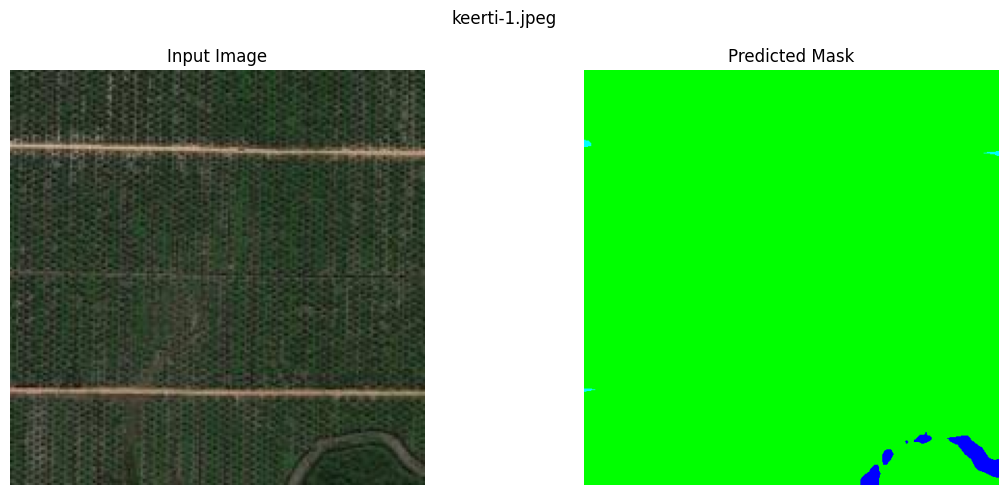

In [ ]:
image_path = "/Users/sahiteepravallika/Desktop/keerti/keerti-1.jpeg"  # your image path here
visualize_prediction_on_image(model, image_path, feature_extractor, class_rgb_values)
